In [67]:
# !pip install tensorflow==2.11.0
import pickle
import h5py
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Flatten
from keras.optimizers import Adam
from keras.regularizers import L2
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, precision_score, recall_score
from sklearn.model_selection import train_test_split

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

print(f'tf_version: {tf.__version__}')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
random.seed(2)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

tf_version: 2.12.0
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [16]:
print(f'Current directory: {os.getcwd()}')
path = '../input/digit-recognizer'
print(f'Files: {filenames} \n')

# Load data    
sample_submission_df = pd.read_csv(os.path.join(path,filenames[0]))
train_df = pd.read_csv(os.path.join(path,filenames[1]))
test_df = pd.read_csv(os.path.join(path,filenames[2]))

display(train_df.head())
display(train_df.info())
display(train_df.describe())

Current directory: /kaggle/working
Files: ['sample_submission.csv', 'train.csv', 'test.csv'] 



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


None

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


### Missing values and Duplicates

In [17]:
# Checking for empty cells
display(train_df.isnull().any().describe())
print('\n')
display(test_df.isnull().any().describe())

count       785
unique        1
top       False
freq        785
dtype: object

count       784
unique        1
top       False
freq        784
dtype: object

In [18]:
# Check for duplicates 

print(f'Number o duplicates: {train_df.duplicated().sum()}')

Number o duplicates: 0


### Count plot

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64


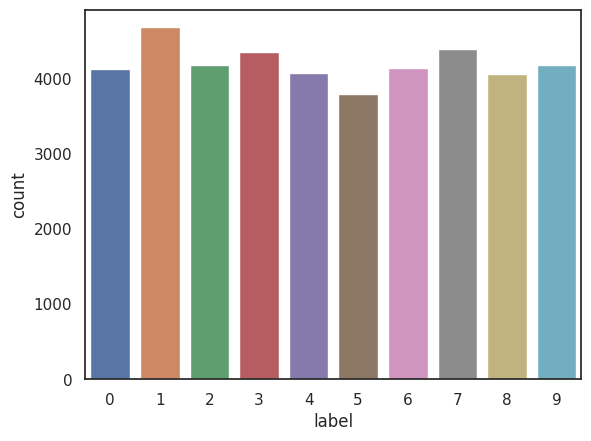

In [19]:
Y_train = train_df['label']
X_train = train_df.drop('label', axis=1)

# Checking distribution
# sns.histplot(train_y, bins=10)
sns.countplot(x=Y_train)
print(Y_train.value_counts())
plt.show()

## Data preprocessing

### 1. Data split

In [20]:
# Split training set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

### 2. Normalization

In [21]:
x_train = X_train.to_numpy() / 255.0
x_val = X_val.to_numpy() / 255.0
y_train = Y_train.to_numpy()
y_val = Y_val.to_numpy()

x_test = test_df.to_numpy() / 255.0
print("Training Set: ", x_train.shape)
print("Test Set: ", x_test.shape)
print("Target Training Set: ", y_train.shape)

Training Set:  (33600, 784)
Test Set:  (28000, 784)
Target Training Set:  (33600,)


### Reshape

In [22]:
# Reshape the flattened images to 28x28x1 3D matrices
x_train_reshaped = x_train.reshape(-1,28,28)
x_test_reshaped = x_test.reshape(-1,28,28)

# y_train_reshaped = to_categorical(y_train, num_classes = 10) # one hot-encode the targets

print(y_train.shape)
print(x_train_reshaped.shape)
print(x_train.shape)

(33600,)
(33600, 28, 28)
(33600, 784)


### Visualizing the digits

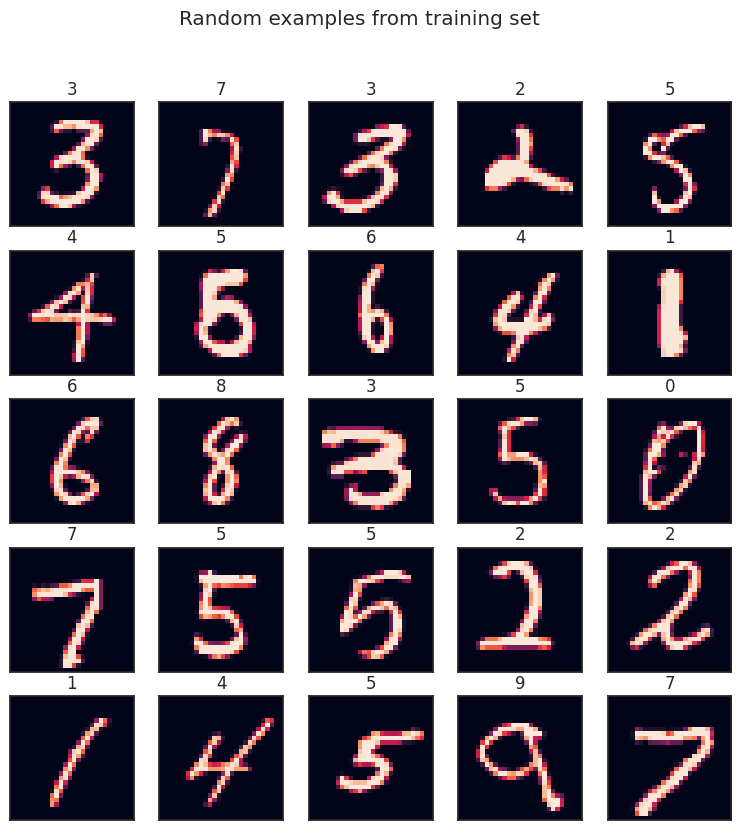

In [23]:
n = 5 # number of rows and columns to plot
fig, ax = plt.subplots(n,n, figsize=(15/np.log(n),15/np.log(n)))
rows_id = random.sample(range(0,x_train.shape[0]), n**2) # pick random images

fig.suptitle("Random examples from training set")
for i, ax in enumerate(ax.flat):
    ax.imshow(x_train_reshaped[rows_id[i]][:,:])
    ax.set_title(y_train[rows_id[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## **3. Model Training**

### 3.1. Regularization tuning

In [24]:
# %%script false --no-raise-error # Prevents this cell from running while run-all

tf.random.set_seed(2)
lambdas = [0, 0.001, 0.003, 0.01, 0.03]
models = [None] * len(lambdas)

# Create multiple models for each regularization param.
for i in range(len(lambdas)):
    models[i]  = Sequential([
      InputLayer(input_shape=(x_train.shape[1],)), # This layer can be omitted 
    #   Flatten(), # Flatten is only necessary if you have a multidimensional tensor feeding the dense layers
      Dense(units=512, kernel_initializer='normal', kernel_regularizer=L2(lambdas[i]), activation='relu', name='layer_1'),
      Dense(units=256, kernel_initializer='normal', kernel_regularizer=L2(lambdas[i]), activation='relu', name='layer_2'),
      Dense(units=256, kernel_initializer='normal', kernel_regularizer=L2(lambdas[i]), activation='relu', name='layer_3'),
      Dense(units=10, kernel_initializer='normal', kernel_regularizer=L2(lambdas[i]), activation='linear', name='layer_4')
    ], name = f'digit_recognition_model{i}')

    models[i].compile(
        loss=SparseCategoricalCrossentropy(from_logits=True),
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
display(models[0].summary())

Model: "digit_recognition_model0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 512)               401920    
                                                                 
 layer_2 (Dense)             (None, 256)               131328    
                                                                 
 layer_3 (Dense)             (None, 256)               65792     
                                                                 
 layer_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 601,610
Trainable params: 601,610
Non-trainable params: 0
_________________________________________________________________


None

In [25]:
# %%script false --no-raise-error # Prevents this cell from running while run-all

histories = [None] * len(lambdas)

for i in range(len(lambdas)):
    histories[i] = models[i].fit(
        x_train,y_train,
        epochs=20,
        batch_size=64,
        validation_data=(x_val, y_val),
        callbacks=[],
        verbose=True,
    )
        
    print('\n Model', i, ' is finished! \n')
    

Epoch 1/20
525/525 [==============================] - 2s 3ms/step - loss: 0.2765 - accuracy: 0.9164 - val_loss: 0.1406 - val_accuracy: 0.9580
Epoch 2/20
525/525 [==============================] - 2s 3ms/step - loss: 0.1036 - accuracy: 0.9680 - val_loss: 0.1314 - val_accuracy: 0.9599
Epoch 3/20
525/525 [==============================] - 2s 3ms/step - loss: 0.0680 - accuracy: 0.9796 - val_loss: 0.0910 - val_accuracy: 0.9725
Epoch 4/20
525/525 [==============================] - 2s 3ms/step - loss: 0.0490 - accuracy: 0.9848 - val_loss: 0.0977 - val_accuracy: 0.9713
Epoch 5/20
525/525 [==============================] - 2s 3ms/step - loss: 0.0367 - accuracy: 0.9887 - val_loss: 0.1374 - val_accuracy: 0.9657
Epoch 6/20
525/525 [==============================] - 2s 4ms/step - loss: 0.0334 - accuracy: 0.9896 - val_loss: 0.0942 - val_accuracy: 0.9749
Epoch 7/20
525/525 [==============================] - 2s 4ms/step - loss: 0.0277 - accuracy: 0.9909 - val_loss: 0.1101 - val_accuracy: 0.9729
Epoch 

### 3.2 Regularization evaluation

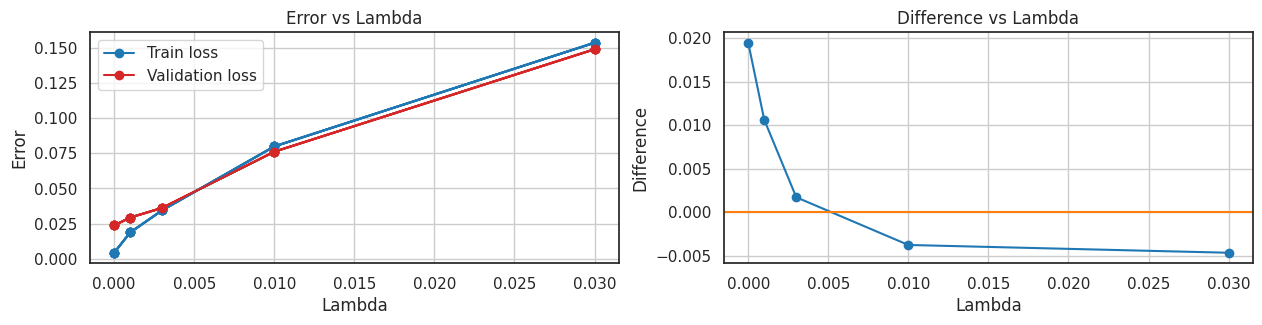

In [27]:
# %%script false --no-raise-error # Prevents this cell from running while run-all
# Picks the last losses for each lambda to compare

losses = []
val_losses = []

err_train = []
err_cv = []

for history in histories:
    err_train.append(1 - history.history['accuracy'][-1])
    err_cv.append(1 - history.history['val_accuracy'][-1])


for history in histories:
    losses.append(history.history['loss'][-1])
    val_losses.append(history.history['val_loss'][-1])


# plt.figure()
# for i in range(len(lambdas)):
#     plt.plot(histories[i].history['loss'])
#     plt.plot(histories[i].history['val_loss'])
#     plt.title('Loss x Epoch per lambda')
#     plt.xlabel('epoch')
# plt.legend(lambdas)
 
# Plot accuracy error per lambda trained
fig, ax = plt.subplots(1,2, figsize=(15,3))
for i in range(len(lambdas)):
    ax[0].plot(lambdas, err_train, color='tab:blue', marker='o')
    ax[0].plot(lambdas, err_cv, color='tab:red', marker='o')
    ax[0].set_title('Error vs Lambda')
    ax[0].set_ylabel('Error')
    ax[0].set_xlabel('Lambda')
    ax[0].grid()
    ax[0].legend(['Train loss', 'Validation loss'])

err_train_float = np.array([float(x) for x in err_train])
err_train_cv = np.array([float(x) for x in err_cv])
ax[1].plot(lambdas, err_train_cv - err_train_float, color='tab:blue', marker='o')
ax[1].axhline(y=0, color='tab:orange')
ax[1].set_title('Difference vs Lambda')
ax[1].set_ylabel('Difference')
ax[1].set_xlabel('Lambda')
ax[1].grid()

**Inference**: According to the graphs, the chosen lambda is 0.003

### 3.3 Final model training

In [28]:
# %%script false --no-raise-error # Prevents this cell from running while run-all
_lambda = 0.003

# Training the final model
model = Sequential([
      InputLayer(input_shape=(x_train.shape[1],)), # This layer can be omitted 
    #   Flatten(), # Flatten is only necessary if you have a multidimensional tensor feeding the dense layers
      Dense(units=128, kernel_initializer='normal', kernel_regularizer=L2(_lambda), activation='relu', name='layer_1'),
      Dense(units=64, kernel_initializer='normal', kernel_regularizer=L2(_lambda), activation='relu', name='layer_2'),
      Dense(units=32, kernel_initializer='normal', kernel_regularizer=L2(_lambda), activation='relu', name='layer_3'),
      Dense(units=10, kernel_initializer='normal', kernel_regularizer=L2(_lambda), activation='linear', name='layer_4')
    ], name = f'final_digit_recognition_model')

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
    
display(model.summary())

# Training for the chosen lambda
history = model.fit(
    x_train,y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[],
    verbose=1,
)

# Save the model as a `.keras` zip archive.
model.save('final_digit_recognition.keras')

print('\n Final model is finished! \n')

Model: "final_digit_recognition_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 128)               100480    
                                                                 
 layer_2 (Dense)             (None, 64)                8256      
                                                                 
 layer_3 (Dense)             (None, 32)                2080      
                                                                 
 layer_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/100
525/525 [==============================] - 2s 3ms/step - loss: 0.9453 - accuracy: 0.7882 - val_loss: 0.6246 - val_accuracy: 0.8832
Epoch 2/100
525/525 [==============================] - 2s 3ms/step - loss: 0.5557 - accuracy: 0.9069 - val_loss: 0.5143 - val_accuracy: 0.9205
Epoch 3/100
525/525 [==============================] - 2s 3ms/step - loss: 0.4893 - accuracy: 0.9285 - val_loss: 0.4914 - val_accuracy: 0.9282
Epoch 4/100
525/525 [==============================] - 2s 3ms/step - loss: 0.4577 - accuracy: 0.9399 - val_loss: 0.4663 - val_accuracy: 0.9367
Epoch 5/100
525/525 [==============================] - 2s 3ms/step - loss: 0.4397 - accuracy: 0.9436 - val_loss: 0.4410 - val_accuracy: 0.9444
Epoch 6/100
525/525 [==============================] - 2s 3ms/step - loss: 0.4242 - accuracy: 0.9485 - val_loss: 0.4408 - val_accuracy: 0.9420
Epoch 7/100
525/525 [==============================] - 2s 3ms/step - loss: 0.4153 - accuracy: 0.9508 - val_loss: 0.4211 - val_accuracy: 0.9483

In [ ]:
# Load the model back from file
model = tf.keras.models.load_model('final_digit_recognition.keras')

model.summary()

## 4. Model evaluation

Final accuracy:  0.9677380919456482
Validation_accuracy:  0.9583333134651184


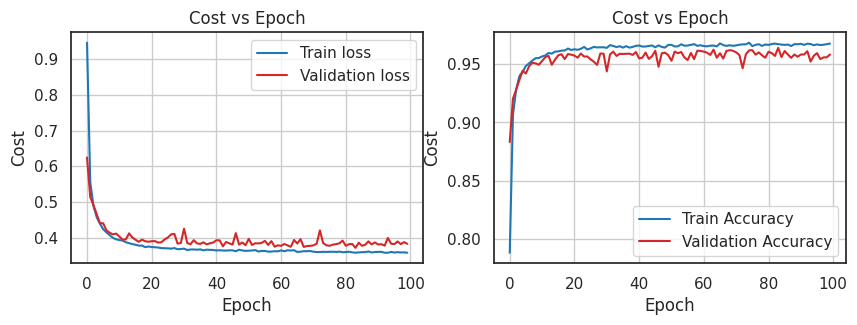

In [41]:
print('Final accuracy: ',history.history['accuracy'][-1])
print('Validation_accuracy: ',history.history['val_accuracy'][-1])

fig, ax = plt.subplots(1,2, figsize=(10,3), sharey=False)
ax[0].plot(history.history['loss'], color='tab:blue')
ax[0].plot(history.history['val_loss'], color='tab:red')
ax[0].set_title('Cost vs Epoch')
ax[0].set_ylabel('Cost')
ax[0].set_xlabel('Epoch')
ax[0].grid()
ax[0].legend(['Train loss', 'Validation loss'])

ax[1].plot(history.history['accuracy'], color='tab:blue')
ax[1].plot(history.history['val_accuracy'], color='tab:red')
ax[1].set_title('Accuracy vs Epoch')
ax[1].set_ylabel('Cost')
ax[1].set_xlabel('Epoch')
ax[1].grid()
ax[1].legend(['Train Accuracy', 'Validation Accuracy'])

263/263 [==============================] - 0s 2ms/step


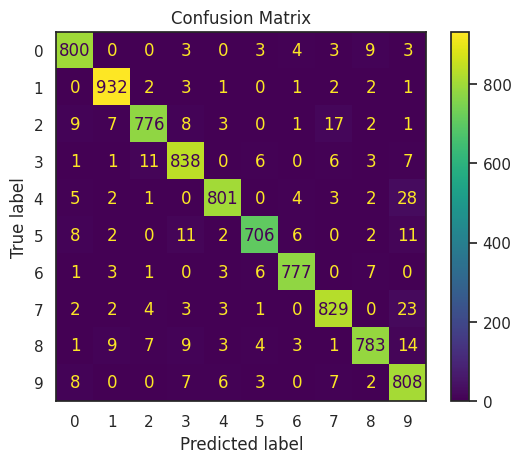

In [75]:
y_hat = model.predict(x_val) # Make predictions
y_hat = np.array([np.argmax(x) for x in y_hat]) # Convert max values to corresponding number

cm = confusion_matrix(y_val, y_hat) # Compute the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

**Inference:** The model misclassified the most 4 digits as 9

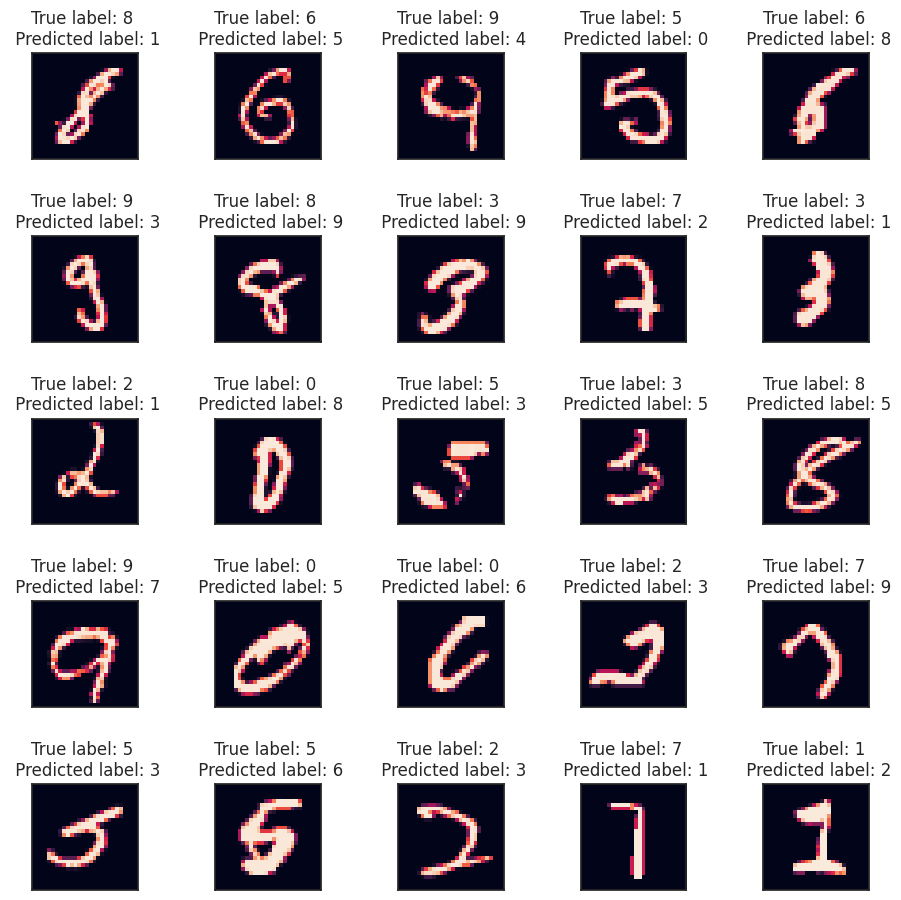

In [103]:
errors = (y_hat - y_val != 0) # Creates a boolean array that is true whenever the model misclassified

y_hat_errors = y_hat[errors]
y_val_errors = y_val[errors]
x_val_errors = x_val[errors].reshape(-1,28,28,1)

n = 5 # number of rows and columns to plot
fig, ax = plt.subplots(n,n, figsize=(15/np.log(n),15/np.log(n)))
fig.tight_layout()
rows_id = random.sample(range(0,x_val_errors.shape[0]), n**2) # pick random images

for i, ax in enumerate(ax.flat):
    ax.imshow(x_val_errors[rows_id[i]][:,:])
    ax.set_title(f'True label: {y_val_errors[rows_id[i]]} \n Predicted label: {y_hat_errors[rows_id[i]]}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()